# 7. KMeans Clustering with Scikit-Learn and MLlib

Implement the K-Means Algorithm using Scikit-Learn and MLlib!

In [1]:
!pip install -q pyspark

In [2]:
%matplotlib inline
from sklearn import datasets
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans
from sklearn import datasets

The dataset class provides access to different public datasets. It will return a scikit-learn bunch: <http://scikit-learn.org/stable/datasets/index.html>

In [3]:
iris = datasets.load_iris()

Convert Scikit Bunch to Pandas Dataframe

In [4]:
iris_df = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target
iris_df["target_name"]=iris['target_names'][iris_df['target']]
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


## 7.1 Cluster the data using the KMeans implementation of scikit-learn!

* Resource: <http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html>
* Measure the runtime for training the model!
* Experiment with different number of clusters! What are your observations!
* Plot the results!

In [10]:
import time


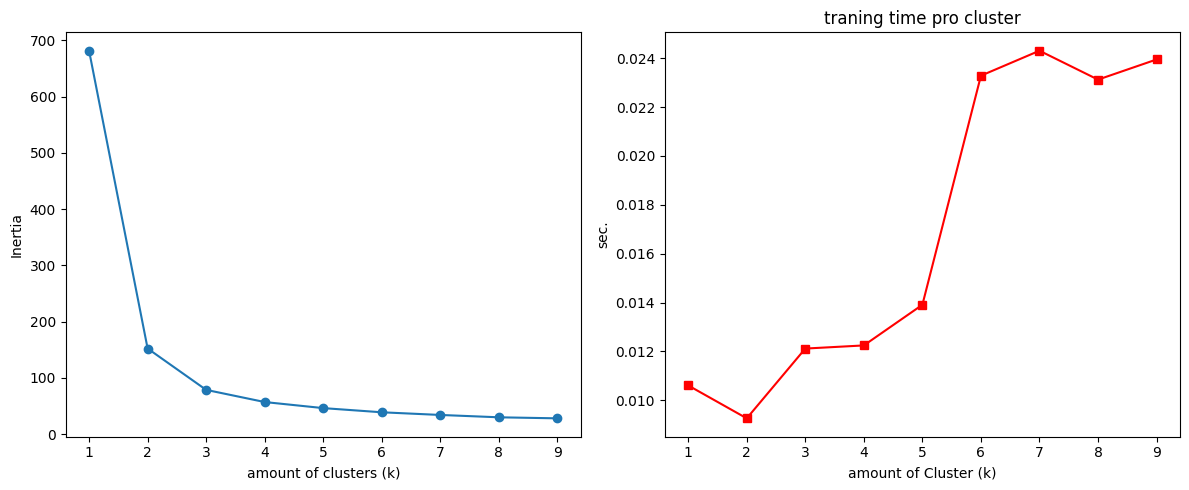

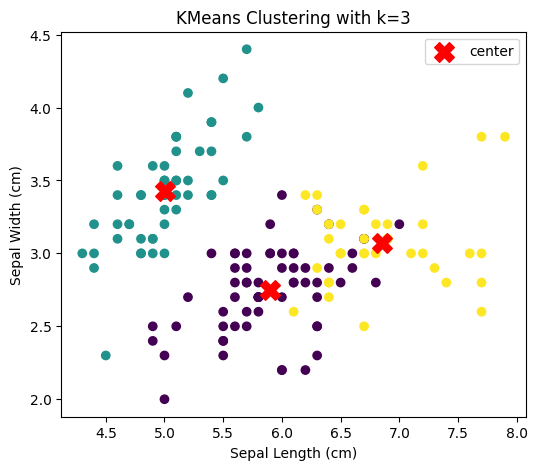

In [14]:
inertias = []
times = []
k_values = range(1, 10)

for k in k_values:
    start = time.time()
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(iris.data)
    end = time.time()

    inertias.append(kmeans.inertia_)
    times.append(end - start)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, inertias, marker='o')
plt.xlabel("amount of clusters (k)")
plt.ylabel("Inertia")

plt.subplot(1, 2, 2)
plt.plot(k_values, times, marker='s', color='red')
plt.title("traning time pro cluster")
plt.xlabel("amount of Cluster (k)")
plt.ylabel("sec.")

plt.tight_layout()
plt.show()

kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(iris.data)

plt.figure(figsize=(6, 5))
plt.scatter(iris.data[:, 0], iris.data[:, 1], c=labels, cmap='viridis')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
            s=200, c='red', marker='X', label='center')
plt.title("KMeans Clustering with k=3")
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Sepal Width (cm)")
plt.legend()
plt.show()

## 7.2 Manual KMeans Clustering

Implement a KMeans Model using Spark MapReduce (Do Not use MLlib version!)!

In [16]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sqrt, pow
import random
from sklearn.decomposition import PCA


Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Cluster 0 center: [5.005999999999999, 3.428000000000001, 1.4620000000000002, 0.2459999999999999]
Cluster 1 center: [5.883606557377049, 2.7409836065573767, 4.388524590163935, 1.4344262295081964]
Cluster 2 center: [6.853846153846154, 3.076923076923076, 5.715384615384614, 2.0538461538461537]


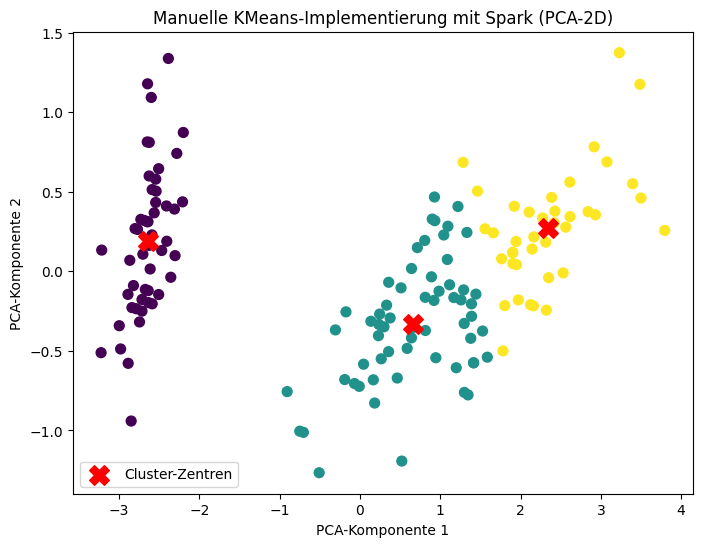

In [20]:


# Session starten
spark = SparkSession.builder.appName("ManualKMeans").getOrCreate()
sc = spark.sparkContext


# Iris-Daten vorbereiten
iris_rdd = spark.sparkContext.parallelize(iris.data.tolist())
iris_data = iris.data.tolist()

X_rdd = sc.parallelize(iris_data)

k = 3
max_iterations = 10

# Zufällige Initialisierung der Zentren
centroids = random.sample(iris.data.tolist(), k)

for iteration in range(max_iterations):
    print(f"Iteration {iteration+1}")

    # Jedes Punkt -> nächstes Zentrum
    def closest_center(point):
        distances = [np.linalg.norm(np.array(point) - np.array(center)) for center in centroids]
        return int(np.argmin(distances)), point

    # Punkt mit Cluster-ID
    clustered = iris_rdd.map(closest_center)

    # Mittelwerte pro Cluster berechnen
    new_centroids = (
        clustered
        .mapValues(lambda x: (np.array(x), 1))
        .reduceByKey(lambda a, b: (a[0]+b[0], a[1]+b[1]))
        .mapValues(lambda v: (v[0] / v[1]).tolist())
        .collect()
    )

    # Zentren updaten
    for cluster_id, center in new_centroids:
        centroids[cluster_id] = center

# Ergebnisse anzeigen
for i, c in enumerate(centroids):
    print(f"Cluster {i} center: {c}")

    # Ergebnis: Cluster-Zuweisung für jeden Punkt
final_assignments = X_rdd.map(lambda point: (point, np.argmin([np.linalg.norm(np.array(point) - np.array(c)) for c in centroids]))).collect()

# PCA zur Visualisierung
points = np.array([p for p, _ in final_assignments])
labels = np.array([label for _, label in final_assignments])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(points)
centers_pca = pca.transform(np.array(centroids))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, marker='X', label='Cluster-Zentren')
plt.title("Manuelle KMeans-Implementierung mit Spark (PCA-2D)")
plt.xlabel("PCA-Komponente 1")
plt.ylabel("PCA-Komponente 2")
plt.legend()
plt.show()

spark.stop()

spark.stop()
